In [15]:
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from skimage import io
import os

import math
import requests

from queue import PriorityQueue

In [16]:
plotly.__version__
pio.renderers.default = "iframe"

In [17]:
np.__version__

'1.16.6'

In [18]:
np.random.seed(0)

In [19]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [20]:
%load_ext autoreload
%autoreload 2

from model import Bicycle, Map
from mppi import MPPI, MPPI_path_follower
from path_planner import a_star_planner
from sim import Simulation

import kmeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
torch.cuda.empty_cache() 

In [22]:
avoid = []

rect = [(20, 0, 80, 50),(20,51,80, 100) ]
circle= []

state_dim = 3
ctrl_dim = 2
u_min = (0., -4.)
u_max = (10., 4.)
step = .05
follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
horizon_depth = 64

#start at 1-5, 45-55, angle -0

In [23]:

# avoid = []

# rect = [(0, 0, 100, 10),(0, 0, 10, 100), (0, 61, 85, 100), (20, 0, 100, 59),(95,0,100,100) ]
# circle= [(20,40, 6), (10, 30, 6),(10, 50, 6)]

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -5.)
# u_max = (10., 5.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

# #start at (11-19, 11-19), angle math.pi/2

In [24]:
# avoid = []

# rect = [(0, 15, 47, 85), (53, 15, 100,85)]
# left_circles = [(47,20+x, 5) for x in range(0, 80, 20)]
# print(left_circles)
# right_circles = [(53,30+x, 5) for x in range(0, 60, 20)]
# circle= left_circles + right_circles

# state_dim = 3
# ctrl_dim = 2
# u_min = (0., -3.)
# u_max = (10., 3.)
# step = .05
# follow_depth = 16 # note: if these parameters are changed, the mppi ones should be changed to match
# horizon_depth = 64

#start at (45-55, 1-5), angle math.pi/2

In [25]:
def get_expert_controls(control_history, horizon_depth, ctrl_dim, interval_start = 0, interval_end = None, interval_step=2, dev="cpu"):
    if(interval_end is None):
        interval_end = len(control_history)-1
    first_rollout = interval_start
    last_rollout = interval_end-horizon_depth
    
    rollout_starts = range(first_rollout, last_rollout+1, interval_step)
    size = len(rollout_starts)
    
    expert_controls = torch.empty([size, horizon_depth, ctrl_dim], dtype = torch.float, device = dev)
    count = 0
    for i in rollout_starts:
        expert_controls[count,:,:] = torch.stack(control_history[i:i+horizon_depth])        
        count+=1
    return expert_controls

In [26]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]

In [28]:
expert_controls = torch.tensor([],device = torch.device('cuda:0')) # used to reset expert_controls from constantly appending
a_star_sim = None
#
for i in range(10):
    for j in range(10):
        x = np.random.uniform(1, 5)
        y = np.random.uniform(45, 55)
        a_star_robot = Bicycle(x, y, 0, 0)
        goal = (90, 50, 1 , 10)

        mppi_sample_center= torch.tensor([0., 0.])
        mppi_sample_covariance = torch.tensor([[16.,0.],[0., 1.]])

        env = Map(goal_point = goal, avoidance_points=avoid, rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))
        a_star_map = Map(goal_point = (a_star_robot.x, a_star_robot.y,4,4), speed_weight = 1, avoidance_points=avoid, 
                         rect_obstacles=rect,circle_obstacles=circle, device = torch.device('cuda:0'))

        def a_star_heuristic(state):     
            return env.terminal_state_cost_batch(state)

        a_star_plan = a_star_planner(a_star_robot, state_dim, ctrl_dim, u_min, u_max, 
                          env.get_obstacles_batch, env.get_distance_batch,
                         iterations = 50000, goal_point = env.goal_point, angle_density = 32, grid_interval = 0.2, goal_tolerance =0.1, 
                                           timestep = step, device=torch.device('cuda:0'))
        
        print (i, j, x, y, "plan ready")
        a_star_follower = MPPI_path_follower(a_star_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max, 
                          a_star_robot.dynamics_batch_horizon, a_star_map, 
                                             a_star_map.running_cost_batch_horizon, a_star_map.terminal_state_cost_batch, a_star_plan.path, 
                         num_samples = 4096, horizon = follow_depth, lambda_=1, sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        print("expert demo started")
        
        a_star_sim = Simulation(a_star_robot, a_star_follower, a_star_map, goal_tolerance = 1, timestep = step)
        
        iter, goal_reached = a_star_sim.run(500, False, True, True, True, 
                                            write_rollout_start = 0, write_rollouts_num = 10, write_rate = 2)

        if not goal_reached:
            #a_star_sim.display_run()
            a_star_sim.display_history()
        else:
            #a_star_sim.display_run()
            #a_star_sim.display_history()
            new_controls = get_expert_controls(a_star_robot.control_history, horizon_depth, ctrl_dim,interval_step = 2, dev = torch.device('cuda:0'))
            
            #expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = 7)
            expert_controls = torch.cat((expert_controls, new_controls), 0)
    
            #expert_means[:, :, -1] = -expert_means[:, :, -1]
            new_controls[:, :, -1] = -new_controls[:, :, -1]
            expert_controls = torch.cat((expert_controls, new_controls), 0)

        
        # losses = []
        # clusters = []
        
        # for num_cluster in range(1, 50, 5):
        #     expert_means, assigned_num, loss = kmeans.k_means_segment(new_controls, k = num_cluster)
        #     losses.append(loss)
        #     clusters.append(num_cluster)
        # plt.plot(clusters, losses)
        # plt.show()
        
        print(expert_controls.shape)



(0, 0, 3.0873932870002867, 49.146619399905234, 'plan ready')
expert demo started
torch.Size([112, 64, 2])
(0, 1, 2.058222448418508, 52.742336894342166, 'plan ready')
expert demo started
torch.Size([226, 64, 2])
(0, 2, 2.824601328866194, 50.68433948868648, 'plan ready')
expert demo started
torch.Size([338, 64, 2])
(0, 3, 1.0751592017454206, 51.17635497075877, 'plan ready')
expert demo started
torch.Size([454, 64, 2])
(0, 4, 3.4483828908896856, 51.16933996874757, 'plan ready')
expert demo started
torch.Size([566, 64, 2])
(0, 5, 4.774992314058497, 51.81820299103484, 'plan ready')
expert demo started
torch.Size([674, 64, 2])
(0, 6, 2.438031602295144, 49.37031953799342, 'plan ready')
expert demo started
torch.Size([786, 64, 2])
(0, 7, 3.7905247837090594, 45.6022547162927, 'plan ready')
expert demo started
torch.Size([898, 64, 2])
(0, 8, 3.6670668617826707, 51.706378696181595, 'plan ready')
expert demo started
torch.Size([1010, 64, 2])
(0, 9, 1.8415302442953636, 46.289262976548535, 'plan rea

torch.Size([2028, 64, 2])
(1, 9, 4.28397291939174, 45.971012757930616, 'plan ready')
expert demo started
torch.Size([2140, 64, 2])
(2, 0, 4.351779629995216, 45.96098407893963, 'plan ready')
expert demo started
torch.Size([2252, 64, 2])
(2, 1, 4.905837860053583, 49.68651201647702, 'plan ready')
expert demo started
torch.Size([2360, 64, 2])
(2, 2, 4.907044352761348, 51.04845519745046, 'plan ready')
expert demo started
torch.Size([2468, 64, 2])
(2, 3, 3.9570543175932067, 45.39187792254321, 'plan ready')
expert demo started
torch.Size([2580, 64, 2])
(2, 4, 2.1312278503056383, 46.20196561213169, 'plan ready')
expert demo started
torch.Size([2696, 64, 2])
(2, 5, 2.1845607900885797, 46.18727718954244, 'plan ready')
expert demo started
torch.Size([2812, 64, 2])
(2, 6, 2.271932717575904, 49.1426299451467, 'plan ready')
expert demo started
torch.Size([2926, 64, 2])
(2, 7, 1.2565899853951374, 51.9247211937002, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([2926, 64, 2])
(2, 8, 3.2664058168263006, 47.65389490939445, 'plan ready')
expert demo started
torch.Size([3038, 64, 2])
(2, 9, 3.0929922138667987, 45.93940510758442, 'plan ready')
expert demo started
torch.Size([3152, 64, 2])
(3, 0, 3.303785982224717, 54.29296197576214, 'plan ready')
expert demo started
torch.Size([3264, 64, 2])
(3, 1, 2.2742758098052946, 51.67410379963682, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([3264, 64, 2])
(3, 2, 1.5271914496175687, 52.16327204118566, 'plan ready')
expert demo started
torch.Size([3380, 64, 2])
(3, 3, 2.1576243717888044, 46.83191362007117, 'plan ready')
expert demo started
torch.Size([3494, 64, 2])
(3, 4, 3.3460517392403326, 45.201075461874936, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([3494, 64, 2])
(3, 5, 4.315760116869452, 45.04695476192547, 'plan ready')
expert demo started
torch.Size([3606, 64, 2])
(3, 6, 3.7112661471849204, 47.70007973192165, 'plan ready')
expert demo started
torch.Size([3718, 64, 2])
(3, 7, 3.9407760884903795, 54.62188545117438, 'plan ready')
expert demo started
torch.Size([3830, 64, 2])
(3, 8, 1.9950125740798321, 50.761573344178366, 'plan ready')
expert demo started
torch.Size([3944, 64, 2])
(3, 9, 3.368167725087356, 50.722519057908734, 'plan ready')
expert demo started
torch.Size([4056, 64, 2])
(4, 0, 1.8923265305624732, 54.527490115169854, 'plan ready')
expert demo started
torch.Size([4172, 64, 2])
(4, 1, 2.7885015144705094, 53.46408672471128, 'plan ready')
expert demo started
torch.Size([4286, 64, 2])
(4, 2, 3.7979171012700172, 47.974369508551334, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([4286, 64, 2])
(4, 3, 4.255191278809908, 48.965057408469846, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([4286, 64, 2])
(4, 4, 4.524412788444646, 50.812728726358586, 'plan ready')
expert demo started
torch.Size([4394, 64, 2])
(4, 5, 4.526941447419411, 51.92531590077766, 'plan ready')
expert demo started
torch.Size([4502, 64, 2])
(4, 6, 3.901017119278562, 50.013243819267025, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([4502, 64, 2])
(4, 7, 4.824334538892895, 51.43990199229637, 'plan ready')
expert demo started
torch.Size([4610, 64, 2])
(4, 8, 2.6954201942327187, 51.063932141279246, 'plan ready')
expert demo started
torch.Size([4722, 64, 2])
(4, 9, 1.076772793237334, 48.015748166745496, 'plan ready')
expert demo started
torch.Size([4838, 64, 2])
(5, 0, 3.64069414997074, 47.90077607210444, 'plan ready')
expert demo started
torch.Size([4950, 64, 2])
(5, 1, 3.472061715995366, 49.28768700945766, 'plan ready')
expert demo started
torch.Size([5060, 64, 2])
(5, 2, 1.541896256889801, 47.982823259560305, 'plan ready')
expert demo started
torch.Size([5174, 64, 2])
(5, 3, 3.2798596428050595, 50.908727612481734, 'plan ready')
expert demo started
torch.Size([5286, 64, 2])
(5, 4, 3.2973009953983152, 51.53200819857133, 'plan ready')
expert demo started
torch.Size([5398, 64, 2])
(5, 5, 3.6084130800067555, 49.31418435433974, 'plan ready')
expert demo started
torch.Size([5508, 64, 2])
(5, 6, 4.5861863834042

torch.Size([5732, 64, 2])
(5, 9, 1.4009075492492045, 54.19482613744674, 'plan ready')
expert demo started
torch.Size([5848, 64, 2])
(6, 0, 3.8569651981964457, 54.98847006567867, 'plan ready')
expert demo started
torch.Size([5960, 64, 2])
(6, 1, 1.597793218631975, 53.68126057368214, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([5960, 64, 2])
(6, 2, 1.6499717387054993, 51.15559564283844, 'plan ready')
expert demo started
torch.Size([6076, 64, 2])
(6, 3, 1.495279931397766, 53.480082293222345, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([6076, 64, 2])
(6, 4, 4.229275834900043, 50.691007386145934, 'plan ready')
expert demo started
torch.Size([6186, 64, 2])
(6, 5, 2.6287331889039987, 45.69166995455138, 'plan ready')
expert demo started
torch.Size([6302, 64, 2])
(6, 6, 3.7897150925782546, 49.535426826780686, 'plan ready')
expert demo started
torch.Size([6412, 64, 2])
(6, 7, 3.8882223978813917, 53.66382325928629, 'plan ready')
expert demo started
torch.Size([6524, 64, 2])
(6, 8, 4.902086020011543, 53.55803342392611, 'plan ready')
expert demo started
torch.Size([6634, 64, 2])
(6, 9, 1.0468563367400079, 48.599780644783635, 'plan ready')
expert demo started
torch.Size([6750, 64, 2])
(7, 0, 3.919962249696232, 46.716296772614406, 'plan ready')
expert demo started
torch.Size([6860, 64, 2])
(7, 1, 3.084146424816517, 45.54337988339254, 'plan ready')
expert demo started
torch.Size([6974, 64, 2])
(7, 2, 1.7999860995856003, 45.18521794460614, 'plan ready')
expert demo started
torch.Size([7090, 64, 2])
(7, 3, 4.17479081342

torch.Size([7200, 64, 2])
(7, 5, 3.817657607694131, 45.318389295313075, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([7200, 64, 2])
(7, 6, 1.658776625991651, 51.21478401499763, 'plan ready')
expert demo started
torch.Size([7314, 64, 2])
(7, 7, 3.3089143544166704, 47.378928213745084, 'plan ready')
expert demo started
torch.Size([7426, 64, 2])
(7, 8, 4.736855991699175, 51.13965955965896, 'plan ready')
expert demo started
torch.Size([7534, 64, 2])
(7, 9, 3.142531212099833, 50.899099763545706, 'plan ready')
expert demo started
torch.Size([7646, 64, 2])
(8, 0, 3.9204881180670785, 48.11944995479602, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([7646, 64, 2])
(8, 1, 2.5928842488643675, 47.09843748975122, 'plan ready')
expert demo started
torch.Size([7760, 64, 2])
(8, 2, 1.7447720235213446, 54.443723899839334, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([7760, 64, 2])
(8, 3, 3.9582031801971502, 49.90458808617567, 'plan ready')
expert demo started
torch.Size([7870, 64, 2])
(8, 4, 1.909658511893293, 47.54356481770393, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([7870, 64, 2])
(8, 5, 1.2321166412955025, 49.34416625558121, 'plan ready')
expert demo started
torch.Size([7986, 64, 2])
(8, 6, 2.2471835279764103, 51.963434888154595, 'plan ready')
expert demo started
torch.Size([8100, 64, 2])
(8, 7, 2.5110073571699236, 46.79603677559635, 'plan ready')
expert demo started
torch.Size([8214, 64, 2])
(8, 8, 1.098714913565325, 45.67249631463248, 'plan ready')
expert demo started
torch.Size([8332, 64, 2])
(8, 9, 3.717571093994269, 49.536968445560454, 'plan ready')
expert demo started
torch.Size([8442, 64, 2])
(9, 0, 3.146316844434889, 53.96671293040342, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([8442, 64, 2])
(9, 1, 4.9613557895868174, 47.16896984398474, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([8442, 64, 2])
(9, 2, 3.652312812400403, 47.633223767371504, 'plan ready')
expert demo started
torch.Size([8554, 64, 2])
(9, 3, 1.0826039978629147, 52.583786538361416, 'plan ready')
expert demo started
torch.Size([8670, 64, 2])
(9, 4, 2.2800686032898714, 48.83463894171898, 'plan ready')
expert demo started
torch.Size([8784, 64, 2])
(9, 5, 3.353268454214423, 53.310484552361906, 'plan ready')
expert demo started
torch.Size([8896, 64, 2])
(9, 6, 3.515927374364595, 53.72650655447396, 'plan ready')
expert demo started
torch.Size([9008, 64, 2])
(9, 7, 2.094168139262543, 52.980468339125636, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([9008, 64, 2])
(9, 8, 1.7425437772238088, 54.527916569719444, 'plan ready')
expert demo started
tensor([10000.], device='cuda:0')


torch.Size([9008, 64, 2])
(9, 9, 3.749953105551261, 47.15507677113558, 'plan ready')
expert demo started
torch.Size([9120, 64, 2])


In [29]:
# a_star_sim.draw_explored(a_star_plan.path, False)

# a_star_sim.display_run()
# a_star_sim.display_history()


1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59


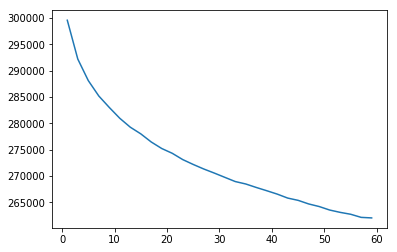

In [35]:
losses = []
clusters = []

for num_cluster in range(1, 61, 2):
    expert_means, assigned_num, loss = kmeans.k_means_segment(expert_controls, k = num_cluster)
    losses.append(loss)
    clusters.append(num_cluster)
    print(num_cluster)
plt.plot(clusters, losses)
plt.show()

In [36]:
num_clusters = 20
expert_means, assigned_to_center, loss = kmeans.k_means_segment(expert_controls, k = num_clusters)
print(assigned_to_center, expert_means.shape)


([437, 459, 446, 454, 463, 443, 447, 422, 444, 449, 488, 478, 467, 473, 444, 467, 470, 463, 485, 421], torch.Size([20, 64, 2]))


In [42]:
use_expert_controls = True
samples = 2048
controls = None

expert_samples = [50 for i in range(20)]

if use_expert_controls:
    if expert_samples is not None:
        samples = samples
        controls = expert_means
    else:
        samples = samples - expert_controls.shape[0]
        controls = expert_controls
    
if(samples <0):
    print("too many expert rollouts")

In [44]:

mppi_sample_center= torch.tensor([0., 0.])
mppi_sample_covariance = torch.tensor([[16.,0.],[0., .1]])
# note: if these parameters are changed, the a-star ones should be changed to match

# changes to 8 clusters

success = 0.
total = 0.
total_it = 0.

for i in range(10):
    for j in range(10):
        x = np.random.uniform(1, 5)
        y = np.random.uniform(45, 55)
        mppi_robot = Bicycle(x, y, 0, 0)
        mppi_goal = (90, 50, 3, 10)

        mppi_map = Map(goal_point = mppi_goal, avoidance_points=avoid, 
                       rect_obstacles=rect,circle_obstacles=circle, speed_weight = 0.1, device = torch.device('cuda:0'))
        mppi_controller = MPPI(mppi_robot, state_dim, ctrl_dim, 
                          mppi_sample_center, mppi_sample_covariance,  u_min, u_max,
                          mppi_robot.dynamics_batch_horizon, mppi_map.running_cost_batch_horizon, mppi_map.terminal_state_cost_batch,
                               expert_rollouts = controls, expert_samples = expert_samples,
                          num_samples = samples, horizon = horizon_depth, lambda_=.1,sample_null_action = True,
                          timestep = step, device=torch.device('cuda:0'))
        mppi_sim = Simulation(mppi_robot, mppi_controller, mppi_map, timestep = step, goal_tolerance = 2)

        iterations, completed = mppi_sim.run(iterations=300, draw_obstacles = False, write_snapshots =False, 
              write_rollouts=True, write_controls = True, write_rollout_start = 0, write_rollouts_num = 20,write_rate = 2)
        #mppi_sim.display_run()
        mppi_sim.display_history()
        print(i, j, completed, iterations)

        if completed:
            success+=1
            total_it += iterations
        total+=1
        
print(success/total)
if success > 0:
    print(total_it/success)



(0, 0, True, 189)


(0, 1, True, 193)


(0, 2, True, 196)


(0, 3, True, 201)


(0, 4, True, 194)
tensor([10000.], device='cuda:0')


(0, 5, False, 300)


(0, 6, True, 190)
tensor([10000.], device='cuda:0')


(0, 7, False, 300)


(0, 8, True, 199)


(0, 9, True, 185)


(1, 0, True, 187)


(1, 1, True, 195)


(1, 2, True, 195)


(1, 3, True, 202)


(1, 4, True, 196)


(1, 5, True, 193)


(1, 6, True, 184)


(1, 7, True, 192)


(1, 8, True, 200)


(1, 9, False, 300)
tensor([10000.], device='cuda:0')


(2, 0, False, 300)


(2, 1, True, 186)
tensor([10000.], device='cuda:0')


(2, 2, False, 300)


(2, 3, True, 194)


(2, 4, True, 185)
tensor([10000.], device='cuda:0')


(2, 5, False, 300)


(2, 6, True, 199)


(2, 7, True, 192)


(2, 8, False, 300)


(2, 9, True, 187)


(3, 0, True, 188)


(3, 1, True, 189)


(3, 2, True, 200)
tensor([10000.], device='cuda:0')


(3, 3, False, 300)


(3, 4, True, 198)


(3, 5, True, 193)


(3, 6, True, 200)


(3, 7, True, 194)
tensor([10000.], device='cuda:0')


(3, 8, False, 300)


(3, 9, True, 199)


(4, 0, True, 197)


(4, 1, False, 300)


(4, 2, True, 189)


(4, 3, True, 185)


(4, 4, True, 208)


(4, 5, True, 193)


(4, 6, True, 197)


(4, 7, False, 300)


(4, 8, False, 300)
tensor([10000.], device='cuda:0')


(4, 9, False, 300)
tensor([10000.], device='cuda:0')


(5, 0, False, 300)


(5, 1, True, 181)


(5, 2, True, 206)


(5, 3, True, 195)


(5, 4, True, 189)


(5, 5, True, 192)


(5, 6, False, 300)


(5, 7, False, 300)


(5, 8, True, 196)


(5, 9, True, 196)


(6, 0, True, 192)
tensor([10000.], device='cuda:0')


(6, 1, False, 300)


(6, 2, True, 188)


(6, 3, True, 193)
tensor([10000.], device='cuda:0')


(6, 4, False, 300)


(6, 5, False, 300)


(6, 6, True, 191)


(6, 7, True, 181)
tensor([10000.], device='cuda:0')


(6, 8, False, 300)


(6, 9, True, 205)


(7, 0, True, 191)


(7, 1, True, 194)


(7, 2, False, 300)


(7, 3, True, 195)


(7, 4, True, 194)
tensor([10000.], device='cuda:0')


(7, 5, False, 300)


(7, 6, True, 205)


(7, 7, True, 188)


(7, 8, True, 189)


(7, 9, True, 202)
tensor([10000.], device='cuda:0')


(8, 0, False, 300)
tensor([10000.], device='cuda:0')


(8, 1, False, 300)


(8, 2, True, 199)


(8, 3, True, 206)


(8, 4, True, 196)


(8, 5, True, 190)
tensor([10000.], device='cuda:0')


(8, 6, False, 300)


(8, 7, True, 186)
tensor([10000.], device='cuda:0')


(8, 8, False, 300)


(8, 9, True, 195)


(9, 0, True, 197)


(9, 1, True, 192)


(9, 2, True, 194)


(9, 3, True, 195)


(9, 4, True, 184)


(9, 5, True, 199)


(9, 6, True, 198)


(9, 7, True, 186)


(9, 8, True, 196)
tensor([10000.], device='cuda:0')


(9, 9, False, 300)
0.73
193.698630137
